# Image super-resolution using Convolution Neural Network (SRCNN)

First, we import necesssary module. We import **tensorflow** for performaing differnt linear algebra manipulations. We import **math** for different mathematical functions. We import keras to make a model, compile it and train it. We use **display** for displaying the images that we have. 

In [1]:
#importing libraries 
import tensorflow as tf

import os
import math
import numpy as np

#performaing differnt linear algebra manipulations
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

We use BSR500 dataset to perform the super-resolution. The images are taken from url, and the directory is assigned to the root_dir variable.

In [2]:
dataset_link = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
directory = keras.utils.get_file(origin=dataset_link, fname="BSR", untar=True)
root_dir = os.path.join(directory, "BSDS500/data")

Now it's time to split the dataset to train and validation set. We randomly split 80% od dataset for training and use 20% of data for validation We first crop the images to 300x300 of size. Additionally, we set 8 as batch size. 

In [3]:
crop_size = (300, 300)
batch_size = 64
upscale_factor = 3
input_size = 300 // upscale_factor

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=crop_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=crop_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


Out of 500 images, we use 400 images for training and use 100 dataet for our validation.

### Now we scale the color-range of each channel on both of out dataset from 0-255 to 0-1.

In [4]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Let us now see one batch from the training dataset and visualize 2 images from a batch it.

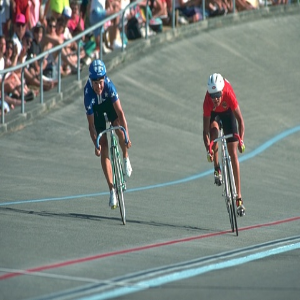

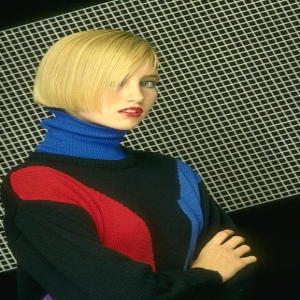

In [5]:
for batch in train_ds.take(1):
  i = 0
  for img in batch:
      display(array_to_img(img))
      i+=1
      if i == 2:
        break

Now we create a test image dataset.

In [6]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

We now process the input images for the test dataset. We use just 1 channel for it (convert the image to greyscale) and we resize the image to 100x100 size. We convert the image to YUV format from RGB format.

We also map our real image and target image one to one in the following function.

In [7]:

def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size=100, upscale_factor=3), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size=100, upscale_factor=3), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Let's now view our greyscale downsampled as well as upsampled images. We display 2 images from a batch.

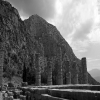

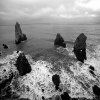

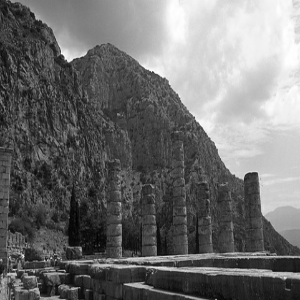

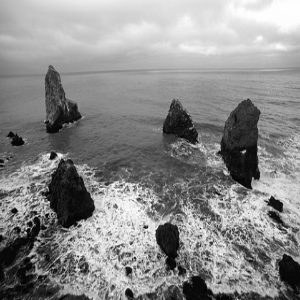

In [8]:
for batch in train_ds.take(1):
  i = 0
  j = 0
  for img in batch[0]:
      display(array_to_img(img))
      i+= 1
      if i == 2:
        break
  for img in batch[1]:
      display(array_to_img(img))
      j += 1
      if j == 2:
        break

## Now we create a model. 
We use 5 convolution layers. Each layer consists of 3x3 kernel size. First layer consists of 32 feature maps, second layer with 64 feature maps, third layer with 128 feature maps, fourth layer with 64 feature maps and final layer with 32 feature maps. We use ReLU as our activation function in each step.

We scale the final output image by 3 times, and finally we return the model from it. It is done using depth_to_space function, which rearranges the feature map tensor from the depth dimension to a block of height*width dimension.



In [9]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 3, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

# Now we train the model.

First we craete a plot_result() function which inputs image, it's prefix and it's title. The function plots original image using matplot lib. Additionally, we add a zoom feature to closely look at the certain part of an image. We use the zoom factor of 2 times, and only the part in the axis from (100, 200) and (300, 400) is shown.

get_lowres_image() function takes in an image and downscales it by 3 times using bicubic interpolation. 

upscale_image() takes in the model and the image as input. It converts it into YCbCr format and as passes it through our model. Our model upsamples the image and returns the output image.

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    #first we convert the image to float datatype
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")


    x1, x2, y1, y2 = 100, 200, 200, 300
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="red")
    plt.savefig(str(prefix) + "-" + title + ".jpg")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize((img.size[0] // upscale_factor, img.size[1] // upscale_factor), PIL.Image.BICUBIC,)


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

## Now we create callbacks.

First, we deifne our callbacks. It initially takes the low resolution image. It consists of 3 functions which is self explanatory. on_epoch_begin initializes an array named psnr which stores the psnr value on each epoch. On ending the epoch, on_epoch_end is called which prints the mean psnr of the output image. On each epoch, an image is displayed which shows the predicted upsampled value. On end of each training batch, on_test_batch_end calculates the psnr of the model. 

In [11]:
class Callback(keras.callbacks.Callback):
    def __init__(self):
        super(Callback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[10]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 4 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

Now we get the summary of the model and save each epoch as checkpoint. Brief summary of what is done in code below is given here:

- The model with minumum loss is saved at filepth ./tmp/checkpoint
- The model's summary is displaed
- MSE is calculated as loss here
- Adam optimizer is used with learning rate 0.01

In [12]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [Callback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

In [ ]:
epochs = 30

model.compile(optimizer='adam', loss=loss_fn,)

history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/30


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(prediction, index, "prediction")
    plot_results(highres_img, index, "highres")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion
The method of mapping an end to end between the low resolution and the high-resolution images with the help of Convolutional Neural Networks is the approach used in the project. The restoration quality of the images from the Super Resolution Convolutional Neural Network (SRCNN) is quite high from other sparse based interpolation methods. The restoration of image copes up with all the three-color channels, to show a better reconstruction quality of images overall.